## CSc 8830: Computer Vision - Assignment 2

Capture a 10 sec video footage using a camera of your choice. The footage should be taken with the camera in hand and you need to pan the camera slightly from left-right or right-left during the 10 sec duration. For all the images, operate at grayscale unless otherwise specified:

A video of 10 sec was recorded from a mobile camera with 1030p resolution and 30FPS frame rate.

#### 1. Pick any image frame from the 10 sec video footage. Pick a region of interest in the image making sure there is an EDGE in that region. Pick a 5 x 5 image patch in that region that constitutes the edge. Perform the steps of CANNY EDGE DETECTION manually and note the pixels that correspond to the EDGE. Compare the outcome with MATLAB or OpenCV or DepthAI’s Canny edge detection function.

Steps involved in Canny Edge Detection:

**1. Convolution:** The code defines a function convolve(image, kernel) to perform convolution between an input image and a given kernel. It computes the valid convolution dimensions and iterates over the image, extracting regions of interest and applying the convolution operation.

**2. Gaussian Blur:** The gaussian_blur(image, kernel_size) function applies a Gaussian blur to the input image. It generates a 2D Gaussian kernel using cv2.getGaussianKernel() and then computes the convolution of the input image with this kernel using the previously defined convolve() function.

**3. Sobel Filtering:** The sobel_filter(image) function applies Sobel filters for edge detection. It defines Sobel kernels for horizontal and vertical edge detection, and then computes gradients in the x and y directions using the convolve() function.

**4. Edge Magnitude and Direction:** The functions edge_magnitude(grad_x, grad_y) and edge_direction(grad_x, grad_y) compute the magnitude and direction of edges respectively, using the gradients obtained from the Sobel filtering step.

**5. Edge Detection and Post-processing:** The code implements non-maximum suppression, thresholding, and hysteresis to detect and refine edges. Non-maximum suppression ensures that only local maxima are retained as edge pixels. Thresholding is used to classify edge pixels as strong, weak, or non-edges based on their magnitude values. Finally, hysteresis helps to connect weak edge pixels to strong ones, forming continuous edges.

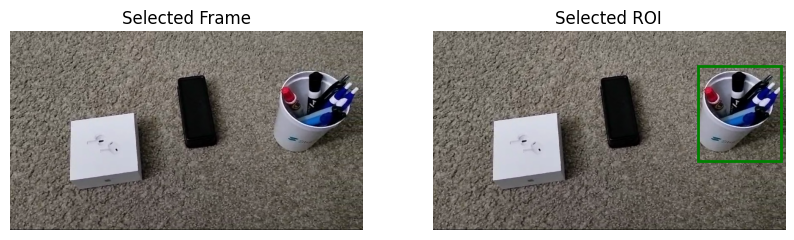

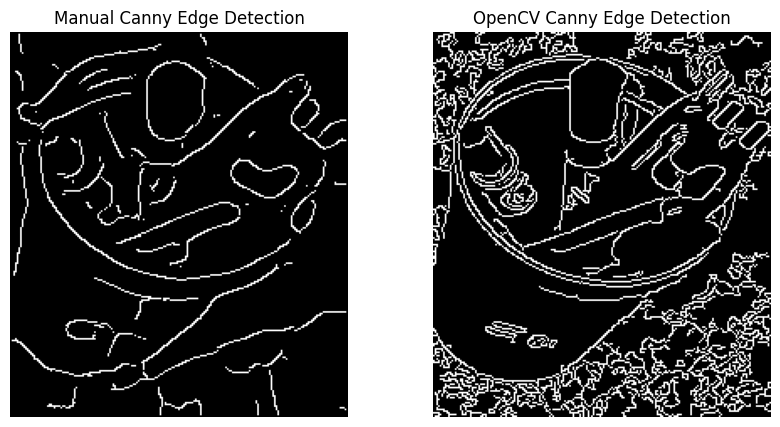

True

In [1]:
import cv2
import numpy as np
from PIL import Image
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt

def canny_edge_detection(image, lowThresholdRatio=0.05, highThresholdRatio=0.09, sigma=5):
    
    # Convert to grayscale
    r, g, b = image[..., 2], image[..., 1], image[..., 0]
    image_gray =  0.2989 * r + 0.5870 * g + 0.1140 * b

    # Gaussian blur
    filter_size = (50,50)
    size_y = filter_size[0] // 2
    size_x = filter_size[1] // 2

    x, y = np.mgrid[-size_y:size_y+1, -size_x:size_x+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    gaussian_filter = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    filtered = ndimage.convolve(image_gray, gaussian_filter)
    
    # Sobel filter
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = ndimage.convolve(filtered, Kx)
    Iy = ndimage.convolve(filtered, Ky)

    # Gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    # Non-maximum suppression
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255
            
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                r = G[i, j-1]
                q = G[i, j+1]
            elif (22.5 <= angle[i,j] < 67.5):
                r = G[i-1, j+1]
                q = G[i+1, j-1]
            elif (67.5 <= angle[i,j] < 112.5):
                r = G[i-1, j]
                q = G[i+1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                r = G[i+1, j+1]
                q = G[i-1, j-1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
            else:
                Z[i,j] = 0
    
    # Double threshold
    highThreshold = Z.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    thresholded = np.zeros((M,N), dtype=np.int32)
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(Z >= highThreshold)
    zeros_i, zeros_j = np.where(Z < lowThreshold)
    weak_i, weak_j = np.where((Z <= highThreshold) & (Z >= lowThreshold))
    
    thresholded[strong_i, strong_j] = strong
    thresholded[weak_i, weak_j] = weak
    
    # Hysteresis
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (thresholded[i, j] == weak):
                if (
                    (thresholded[i+1, j-1] == strong) or (thresholded[i+1, j] == strong) or
                    (thresholded[i+1, j+1] == strong) or (thresholded[i, j-1] == strong) or
                    (thresholded[i, j+1] == strong) or (thresholded[i-1, j-1] == strong) or
                    (thresholded[i-1, j] == strong) or (thresholded[i-1, j+1] == strong)
                ):
                    thresholded[i, j] = strong
                else:
                    thresholded[i, j] = 0
    
    return thresholded

# Global variables to store ROI coordinates
roi_x, roi_y, roi_width, roi_height = -1, -1, -1, -1
selecting_roi = False

# Mouse callback function to select ROI
def select_roi(event, x, y, flags, param):
    global roi_x, roi_y, roi_width, roi_height, selecting_roi

    if event == cv2.EVENT_LBUTTONDOWN:
        roi_x, roi_y = x, y
        selecting_roi = True
    elif event == cv2.EVENT_MOUSEMOVE and selecting_roi:
        roi_width, roi_height = x - roi_x, y - roi_y
    elif event == cv2.EVENT_LBUTTONUP:
        roi_width, roi_height = x - roi_x, y - roi_y
        selecting_roi = False

# Load the video
video_path = 'cv-10s_video_ass2.mp4'
cap = cv2.VideoCapture(video_path)

# Select a frame index
frame_index = 150

# Read the frame
for i in range(frame_index+1):
    ret, frame = cap.read()

# Create a window and set mouse callback function
window_name = 'Select ROI (Press "q" to Quit)'
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, select_roi)

# Select ROI
while True:
    clone = frame.copy()
    if not selecting_roi and roi_width > 0 and roi_height > 0:
        cv2.rectangle(clone, (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (0, 255, 0), 2)
    cv2.imshow(window_name, clone)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Close the window
cv2.destroyAllWindows()

# Extract ROI
roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

# Manual Canny edge detection 
edge_map = canny_edge_detection(roi)

# Convert the patch to grayscale
gray_patch = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Use OpenCV's Canny edge detection function
low_threshold = np.int32(50)
high_threshold = np.int32(255)
canny_opencv = cv2.Canny(gray_patch, low_threshold, high_threshold)

# Display the selected frame with ROI
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Selected Frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Selected ROI')
plt.axis('off')
plt.gca().add_patch(plt.Rectangle((roi_x, roi_y), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none'))

plt.show()

# Display the manually implemented Canny edge detection result and OpenCV's Canny edge detection result side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(edge_map, cmap='gray')
plt.title('Manual Canny Edge Detection')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(canny_opencv, cmap='gray')
plt.title('OpenCV Canny Edge Detection')
plt.axis('off')

plt.show()

# Save the results
cv2.imwrite('manual_canny_edge_detection.png', edge_map)
cv2.imwrite('opencv_canny_edge_detection.png', canny_opencv)

#### 2. Pick any image frame from the 10 sec video footage. Pick a region of interest in the image making sure there is a CORNER in that region. Pick a 5 x 5 image patch in that region that constitutes the edge. Perform the steps of HARRIS CORNER DETECTION manually and note the pixels that correspond to the CORNER. Compare the outcome with MATLAB or OpenCV or DepthAI’s  Harris corner detection function.

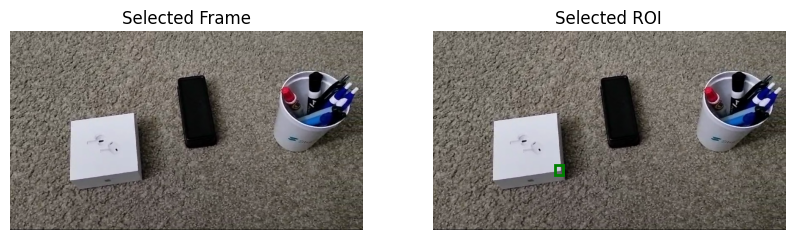

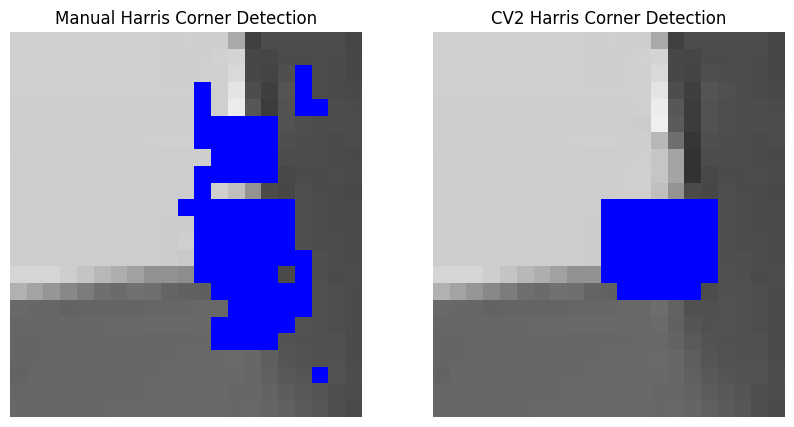

True

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_harris_corners(input_img, k, window_size, threshold):
    
    corner_list = []
    output_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_GRAY2RGB)
    
    offset = int(window_size/2)
    y_range = input_img.shape[0] - offset
    x_range = input_img.shape[1] - offset
    
    dy, dx = np.gradient(input_img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            
            # Values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1
            
            # The variable names are representative of 
            # the variables of the Harris corner equation
            windowIxx = Ixx[start_y : end_y, start_x : end_x]
            windowIxy = Ixy[start_y : end_y, start_x : end_x]
            windowIyy = Iyy[start_y : end_y, start_x : end_x]
            
            # Sum of squares of intensities of partial derivatives 
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            # Calculate determinant and trace of the matrix
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            
            # Calculate r for Harris Corner equation
            r = det - k * (trace**2)

            if r > threshold:
                corner_list.append([x, y, r])
                output_img[y, x] = (0, 0, 255)
    
    return corner_list, output_img 

def harris_corner_detection(gray, ksize, k, threshold):
    
    # Harris corner detection
    dst = cv2.cornerHarris(gray, blockSize=ksize, ksize=ksize, k=k)
    
    # Thresholding
    dst_thresh = np.zeros_like(dst)
    dst_thresh[dst > threshold * dst.max()] = 255
    
    # Dilate the detected corners to make them more visible
    dst_thresh = cv2.dilate(dst_thresh, None)
    
    # Create an output image with corners drawn
    output_img = cv2.cvtColor(gray.copy(), cv2.COLOR_GRAY2RGB)
    output_img[dst_thresh > 0] = [0, 0, 255]  # Draw corners in red
    
    return dst_thresh, output_img

# Function to select ROI from the previous code
def select_roi(event, x, y, flags, param):
    global roi_x, roi_y, roi_width, roi_height, selecting_roi

    if event == cv2.EVENT_LBUTTONDOWN:
        roi_x, roi_y = x, y
        selecting_roi = True
    elif event == cv2.EVENT_MOUSEMOVE and selecting_roi:
        roi_width, roi_height = x - roi_x, y - roi_y
    elif event == cv2.EVENT_LBUTTONUP:
        roi_width, roi_height = x - roi_x, y - roi_y
        selecting_roi = False

# Load the video
video_path = 'cv-10s_video_ass2.mp4'
cap = cv2.VideoCapture(video_path)

# Select a frame index
frame_index = 150

# Read the frame
for i in range(frame_index+1):
    ret, frame = cap.read()

# Create a window and set mouse callback function
window_name = 'Select ROI (Press "q" to Quit)'
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, select_roi)

# Select ROI
roi_x, roi_y, roi_width, roi_height = -1, -1, -1, -1
selecting_roi = False
while True:
    clone = frame.copy()
    if not selecting_roi and roi_width > 0 and roi_height > 0:
        cv2.rectangle(clone, (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (0, 255, 0), 2)
    cv2.imshow(window_name, clone)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Close the window
cv2.destroyAllWindows()

# Extract ROI
roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

# Convert the ROI to grayscale
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Set parameters for Harris corner detection
k = 0.05 # Harris detector free parameter
window_size = 5 # Neighborhood size for corner detection
threshold = 10000.00 # Threshold for corner response

# Perform manual Harris corner detection on the image patch
corner_list, manual_corner_img = find_harris_corners(roi_gray, k, window_size, threshold)

# Perform Harris corner detection
corner_response, cv2_corner_img = harris_corner_detection(roi_gray, window_size, k, threshold=0.1)

# Display the selected frame with ROI
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Selected Frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Selected ROI')
plt.axis('off')
plt.gca().add_patch(plt.Rectangle((roi_x, roi_y), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none'))

plt.show()
    
# Display the results using Matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(manual_corner_img, cmap='gray')
plt.title('Manual Harris Corner Detection')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2_corner_img, cmap='gray')
plt.title('CV2 Harris Corner Detection')
plt.axis('off')

plt.show()

# Save the results
cv2.imwrite('manual_harris_corner_detection.png', manual_corner_img)
cv2.imwrite('opencv_harris_corner_detection.png', cv2_corner_img)

3. Consider an image pair from your footage where the images are separated by at least 2 seconds. Also ensure there is at least some overlap of scenes in the two images. 

    a. Pick a pixel (super-pixel patch as discussed in class) on image 1 and a corresponding pixel ((super-pixel patch as discussed in class)) on image 2 (the pixel on image 2 that corresponds to the same object area on image 1). Compute the SIFT feature for each of these 2 patches. Compute the sum of squared difference (SSD) value between the SIFT vector for these two pixels. Use MATLAB or Python or C++ implementation -- The MATLAB code for SIFT feature extraction and matching can be downloaded from here: https://www.cs.ubc.ca/~lowe/keypoints/ (Please first read the ReadMe document in the folder to find instructions to execute the code).

    b. Compute the Homography matrix between these two images using MATLAB or Python or C++ implementation. Compute its inverse.
You can make assumptions as necessary, however, justify them in your answers/description.


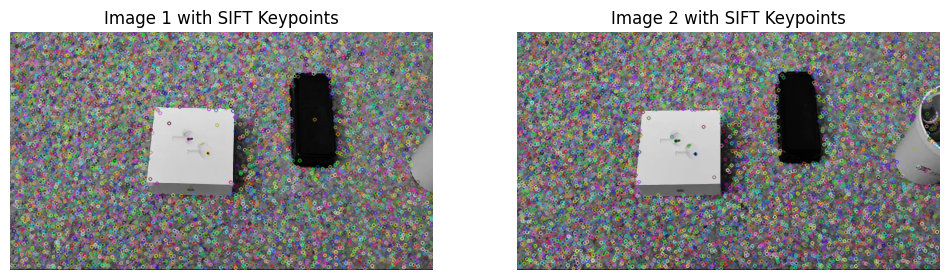

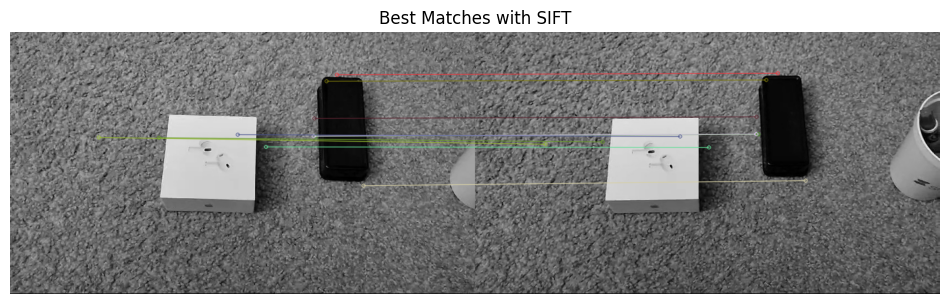

Sum of Squared Difference (SSD) between SIFT vectors: 1425.0


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the video
video_path = "cv-10s_video_ass2.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize variables
prev_frame_time = None
selected_frames = []

# Iterate through the frames of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Get the timestamp of the current frame
    current_frame_time = cap.get(cv2.CAP_PROP_POS_MSEC)

    # If it's the first frame or the time difference is at least 2 seconds
    if prev_frame_time is None or current_frame_time - prev_frame_time >= 2000:
        selected_frames.append((current_frame_time, frame))
        prev_frame_time = current_frame_time

        if len(selected_frames) == 2:
            break

# Release the video capture
cap.release()

# Check if at least two frames were selected
if len(selected_frames) < 2:
    print("Couldn't find two frames with at least 2-second difference.")
    exit()

# Save the selected frames as images
for i, (timestamp, frame) in enumerate(selected_frames):
    cv2.imwrite(f"frame_{i+1}.jpg", frame)

# Load the images
image1 = cv2.imread('frame_1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('frame_2.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Match descriptors between the two images
bf = cv2.BFMatcher()
matches = bf.match(descriptors1, descriptors2)

# Initialize an empty image for drawing keypoints
image_with_keypoints1 = cv2.drawKeypoints(image1, keypoints1, None)
image_with_keypoints2 = cv2.drawKeypoints(image2, keypoints2, None)

# Display the images with keypoints using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_with_keypoints1, cmap='gray')
ax[0].set_title('Image 1 with SIFT Keypoints')
ax[0].axis('off')
ax[1].imshow(image_with_keypoints2, cmap='gray')
ax[1].set_title('Image 2 with SIFT Keypoints')
ax[1].axis('off')
plt.show()

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
matched_img = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the images with keypoints using matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(matched_img)
ax.set_title('Best Matches with SIFT')
ax.axis('off')
plt.show()

# Convert keypoints to numpy array
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute SSD between SIFT vectors for the corresponding keypoints
sift_diff = np.sum((descriptors1[matches[0].queryIdx] - descriptors2[matches[0].trainIdx]) ** 2)

print("Sum of Squared Difference (SSD) between SIFT vectors:", sift_diff)


In [9]:
### 3(b)

# Compute the homography matrix using RANSAC
homography_matrix, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC)

# Compute the inverse of the homography matrix
inverse_homography_matrix = np.linalg.inv(homography_matrix)

# Print the homography matrix and its inverse
print("Homography Matrix:")
print(homography_matrix)
print("\nInverse of Homography Matrix:")
print(inverse_homography_matrix)


Homography Matrix:
[[ 9.89162617e-01  2.52675557e-02 -3.61535864e+01]
 [-3.87032513e-02  9.85763178e-01  2.21012998e+01]
 [ 1.05751782e-05  6.45250418e-06  1.00000000e+00]]

Inverse of Homography Matrix:
[[ 1.00953775e+00 -2.61196431e-02  3.70756883e+01]
 [ 3.98818256e-02  1.01355736e+00 -2.09590640e+01]
 [-1.09333792e-05 -6.26376321e-06  9.99743156e-01]]


#### 4. Implement an application that will compute and display the INTEGRAL image feed along with the RGB feed. You cannot use a built-in function such as “output = integral_image(input)”

[[1.0200000e+02 2.0000000e+02 2.9400000e+02 ... 9.7518000e+04
  9.7628000e+04 9.7740000e+04]
 [2.0200000e+02 3.9200000e+02 5.7800000e+02 ... 1.9519800e+05
  1.9541800e+05 1.9564800e+05]
 [3.0000000e+02 5.7900000e+02 8.5600000e+02 ... 2.9302000e+05
  2.9335100e+05 2.9370100e+05]
 ...
 [4.9243000e+04 9.8137000e+04 1.4667500e+05 ... 4.2253513e+07
  4.2297118e+07 4.2340719e+07]
 [4.9334000e+04 9.8321000e+04 1.4695100e+05 ... 4.2322543e+07
  4.2366212e+07 4.2409876e+07]
 [4.9338000e+04 9.8329000e+04 1.4696300e+05 ... 4.2326260e+07
  4.2369930e+07 4.2413595e+07]]


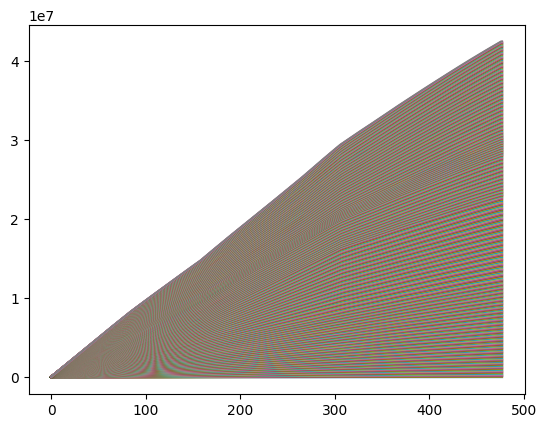

In [5]:
# We first compute integral of an rgb image before applying to to a stream

import cv2
import numpy as np
from matplotlib import pyplot as plt

frame = cv2.imread("/Users/nagurshareefshaik/Desktop/MSCS/Spring 2024/CV/Assignment-2/frame_2.jpg")

# Define function to compute integral image
def compute_integral_image(frame):
    gray_clr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    height, width = gray_clr.shape

    integral_image = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            integral_image[i][j] = int(gray_clr[i][j])

    for i in range(1, width):
        integral_image[0][i] += integral_image[0][i - 1]

    for j in range(1, height):
        integral_image[j][0] += integral_image[j - 1][0]

    for i in range(1, height):
        for j in range(1, width):
            integral_image[i][j] = integral_image[i - 1][j] + integral_image[i][j - 1] - integral_image[i - 1][j - 1] + gray_clr[i][j]

    return integral_image

intergal_image = compute_integral_image(frame)

print(intergal_image)
np.savetxt('integral_image.txt', intergal_image, fmt='%d')
plt.plot(intergal_image)
plt.savefig("integral_image.jpg")
plt.show()

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import depthai  # Import depthai library

# Create DepthAI pipeline
pipeline = depthai.Pipeline()

# Define sources and output for the pipeline
cam_rgb = pipeline.createColorCamera()
xout_rgb = pipeline.createXLinkOut()
xout_integral = pipeline.createXLinkOut()

# Set properties for the color camera
cam_rgb.setPreviewSize(300, 300)
cam_rgb.setResolution(depthai.ColorCameraProperties.SensorResolution.THE_1080_P)
cam_rgb.setInterleaved(False)
cam_rgb.setColorOrder(depthai.ColorCameraProperties.ColorOrder.RGB)

# Output stream for RGB frames
xout_rgb.setStreamName("rgb")

# Output stream for integral image
xout_integral.setStreamName("integral")

# Linking color camera to output streams
cam_rgb.preview.link(xout_rgb.input)
cam_rgb.preview.link(xout_integral.input)

# Connect to the device
with depthai.Device(pipeline) as device:
    # Start the pipeline
    device.startPipeline()

    # Define function to compute integral image
    def compute_integral_image(frame):
        gray_clr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        height, width = gray_clr.shape

        integral_image = np.zeros((height, width))

        for i in range(height):
            for j in range(width):
                integral_image[i][j] = int(gray_clr[i][j])

        for i in range(1, width):
            integral_image[0][i] += integral_image[0][i - 1]

        for j in range(1, height):
            integral_image[j][0] += integral_image[j - 1][0]

        for i in range(1, height):
            for j in range(1, width):
                integral_image[i][j] = integral_image[i - 1][j] + integral_image[i][j - 1] - integral_image[i - 1][j - 1] + gray_clr[i][j]

        return integral_image

    # Main loop to capture and process frames
    while True:
        # Get the frames from the output streams
        in_rgb = device.getOutputQueue(name="rgb", maxSize=1).get()
        in_integral = device.getOutputQueue(name="integral", maxSize=1).get()

        # Read and display RGB frame
        frame_rgb = in_rgb.getCvFrame()
        cv2.imshow("RGB Stream", frame_rgb)

        # Compute integral image and display
        integral_image = compute_integral_image(frame_rgb)
        cv2.imshow("Integral Image", integral_image.astype(np.uint8))

        # Check for 'q' key press to exit
        if cv2.waitKey(1) == ord('q'):
            break

    # Release resources
    cv2.destroyAllWindows()


/var/folders/cv/flgh8s7960bc7q380pyn0c6m0000gn/T/ipykernel_64583/2275050118.py:33: DeprecationWarning: Device(pipeline) starts the pipeline automatically. Use Device() and startPipeline(pipeline) otherwise
  device.startPipeline()


##### 5. Implement the image stitching for a 360 degree panoramic output. This should function in real-time. You can use any type of features. You can use built-in libraries/tools provided by OpenCV or DepthAI API. You cannot use any built-in function that does output = image_stitch(image1, image2). You are supposed to implement the image_stitch() function

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_stitch(img1, img2):
    # Convert images to Gray
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    
    # Initialize BFMatcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test to select good matches
    good = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)
    matches = np.asarray(good)
    
    if len(matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        # Find Homography matrix using RANSAC
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Warp image1 onto image2
        warped_img1 = cv2.warpPerspective(img1, H, (img2.shape[1] + img1.shape[1], img2.shape[0]))
        
        # Combine images
        stitched_image = warped_img1.copy()
        stitched_image[0:img2.shape[0], 0:img2.shape[1]] = img2
        
        return stitched_image
    else:
        raise AssertionError("Can’t find enough keypoints for stitching.")
    

# Load all images covering 360 degrees (1,2,3)
img_paths = [f'pan-images/trends-lab/img{i}.jpeg' for i in range(1, 4)]
images = [cv2.imread(img_path) for img_path in img_paths]

# Stitch images together
panorama = images[0]
for i in range(1, len(images)):
    stitched = image_stitch(panorama, images[i])
    if stitched is not None:
        panorama = stitched

# Save image
cv2.imwrite('panoramic_output1.jpg',panorama)

# Display stitched image
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Load all images covering 360 degrees (4,5,6)
img_paths = [f'pan-images/trends-lab/img{i}.jpeg' for i in range(4, 7)]
images = [cv2.imread(img_path) for img_path in img_paths]

# Stitch images together
panorama = images[0]
for i in range(1, len(images)):
    stitched = image_stitch(panorama, images[i])
    if stitched is not None:
        panorama = stitched

# Save image
cv2.imwrite('panoramic_output2.jpg',panorama)

# Display stitched image
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Load all images covering 360 degrees (6,7)
img_paths = [f'pan-images/trends-lab/img{i}.jpeg' for i in range(6, 8)]
images = [cv2.imread(img_path) for img_path in img_paths]

# Stitch images together
panorama = images[0]
for i in range(1, len(images)):
    stitched = image_stitch(panorama, images[i])
    if stitched is not None:
        panorama = stitched

# Save image
cv2.imwrite('panoramic_output3.jpg',panorama)

# Display stitched image
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()